# Import modules

In [1]:
import os
import numpy as np
import torch
import os
import re
import json
import argparse
import pandas as pd
import random
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5ForConditionalGeneration
from rich.table import Column, Table
from rich import box
from rich.console import Console
console = Console(record=True)
from torch import cuda
import nltk
import evaluate
import pdfkit
from pdf2image import convert_from_path
import glob, sys, fitz
from torch.utils.data import Dataset, DataLoader
from collections import namedtuple

from PIL import Image, ImageDraw, ImageOps, ImageFont
import requests
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Pix2StructConfig

import textwrap
import math

import matplotlib.pyplot as plt
from rouge import Rouge

/Users/rohanwadhawan/miniconda3/envs/nlg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data visualization

In [2]:
def read_captions():
    captions_dict = dict(pd.read_json(os.path.join(os.getcwd(), "data", "captions.json"))["captions"])
    return captions_dict

In [3]:
captions_dict = read_captions()

In [4]:
def read_problem_list(captions_dict = None):
    
    problem_list = pd.read_json(os.path.join(os.getcwd(), "data", "scienceqa", "problems.json"))
    return problem_list

In [5]:
problem_list = read_problem_list(captions_dict)

In [6]:
problem_list.keys()

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207,
            21208],
           dtype='int64', length=21208)

In [7]:
print(problem_list[1]["image"])

image.png


In [8]:
print(problem_list[1]["split"])

train


In [9]:
print(problem_list[1]["task"])

closed choice


In [10]:
print(problem_list[2]["hint"])

The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the balls traveled when launched from a 45° angle to the distances the balls traveled when launched from a 30° angle.
Figure: a catapult for launching ping pong balls.


In [11]:
len(problem_list.keys())

21208

In [12]:
choice_len = []
for i in range(len(problem_list.keys())):
    choice_len.append(len(problem_list[i+1]["choices"]))
print(np.unique(choice_len))
#     print(problem_list[i+1]["choices"])

[2 3 4 5]


In [13]:
print(problem_list[1]["answer"])

0


In [14]:
print(problem_list[1]["solution"])

To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.


In [15]:
print(len((problem_list[1]["lecture"]).split(" ")))

60


In [16]:
# problem_list[1]

# Get specific data split data frames

In [17]:
def read_pid_splits():
    with open(os.path.join(os.getcwd(), "data", "scienceqa", "pid_splits.json")) as json_file:
        data = json.load(json_file)
    return data

In [18]:
pid_splits = read_pid_splits()

In [19]:
print(pid_splits.keys())

dict_keys(['train', 'val', 'test', 'trainval', 'minitrain', 'minival', 'minitest', 'tiny_train', 'tiny_val', 'tiny_test'])


In [20]:
def get_specific_split(pid_splits, split_name="train"):
    return [int(i) for i in pid_splits[split_name]]

In [21]:
train_split = get_specific_split(pid_splits, split_name = "train")

# Prepare HTML - JPEG content

In [22]:
options = ["A", "B", "C", "D", "E"]

In [23]:
def create_question_tag():
    question_tag = "<h2>{question_content}</h2>"
    return question_tag

In [24]:
def create_choice_tag():
    choice_tag = "<h3>{choice_content}</h3>"
    return choice_tag

In [25]:
def create_img_tag():
    img_tag = '<img src="{img_source}">'
    return img_tag

In [26]:
def create_context_tag():
    context_tag = "<p>{context_content}</p>"
    return context_tag

In [27]:
def create_lecture_tag():
    lecture_tag = "<p>{lecture_content}</p>"
    return lecture_tag

In [28]:
def get_choice_text(problem, options, verbose = False):
    choices = problem['choices']
    choice_list = []
    for i, c in enumerate(choices):
        choice_list.append("({}) {}".format(options[i], c))
    choice_txt = " ".join(choice_list)
    if verbose:
        print(choice_txt)
    
    return choice_txt

In [29]:
def create_html_template_modular():
    html_template = \
        '''
            <html>
                <body style="background-color:white;">
                    {question_tag}
                    {choice_tag}
                    {img_tag}
                    {context_tag}
                    {lecture_tag}
                </body>
            </html>
        '''
    return html_template

In [30]:
def create_html_template_modular_v2(tags=[]):
    html_template = '<html> <body style="background-color:white;">'
    for tag in tags:
        html_template += "{" + tag + "}"           
    html_template+="</body></html>"

    return html_template

In [31]:
def create_html_file_modular(params, df, sample_num=None, html_type=1):

    # create individual tags
    
    # Question
    if params["set_question_as_header"] == False:
        question_tag = create_question_tag().format(question_content = df[sample_num]["question"])
        
    else:
        question_tag = ""
        
    # Choices
    if params["set_question_as_header"] == False:
        choice_tag = create_choice_tag().format(choice_content = get_choice_text(df[sample_num], params["options"]))
        
    else:
        choice_tag = ""
        
    # Image source
    if df[sample_num]["image"] is not None:
        img_tag = create_img_tag().format(img_source = os.path.join(os.getcwd(), "data", df[sample_num]["split"], \
                              str(sample_num), df[sample_num]['image']))
    else:
        img_tag = ""

    # Context
    if df[sample_num]["hint"] is not None and params["skip_text_context"] == False:
        context_tag = create_context_tag().format(context_content = df[sample_num]["hint"])    
    else:
        context_tag = ""


    # Lecture
    if df[sample_num]["lecture"] is not None and params["skip_lecture"] == False:
        lecture_tag = create_lecture_tag().format(lecture_content = df[sample_num]['lecture']) 

    else:
        lecture_tag = ""
    
    # compose tags to html
    if html_type==1: # QM I CL
        tags = ["question_tag", "choice_tag", "img_tag", "context_tag", "lecture_tag"]
        
    elif html_type==2: # QM CL I
        tags = ["question_tag", "choice_tag", "context_tag", "lecture_tag", "img_tag"]
    
    elif html_type==3: # QM I
        tags = ["question_tag", "choice_tag", "img_tag"]
    
    
    final_html_file = create_html_template_modular_v2(tags).format(question_tag = question_tag, choice_tag = choice_tag, \
                                          img_tag = img_tag, context_tag = context_tag, \
                                          lecture_tag = lecture_tag)
    
    return final_html_file

In [32]:
params = {
    "set_question_as_header": False,
    "skip_text_context":False,
    "skip_lecture":False,
    "options":options
}

In [33]:
test_html_file = create_html_file_modular(params, problem_list, sample_num=2)

In [34]:
print(test_html_file)

<html> <body style="background-color:white;"><h2>Identify the question that Tom and Justin's experiment can best answer.</h2><h3>(A) Do ping pong balls stop rolling along the ground sooner after being launched from a 30° angle or a 45° angle? (B) Do ping pong balls travel farther when launched from a 30° angle compared to a 45° angle?</h3><img src="/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/eeevqa/data/train/2/image.png"><p>The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the 

In [35]:
def create_html_template(choice = None):
    if choice is not None:
        html_template = \
        '''
            <html>
                <img src="{img_source}">
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        '''
    else:
        html_template = \
        '''
            <html>
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        '''
    return html_template

In [36]:
html_template = create_html_template(choice="img")
print(html_template)


            <html>
                <img src="{img_source}">
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        


In [37]:
def create_html_file(html_template, df, sample_num=None):

    # Image source
    img_source = os.path.join(os.getcwd(), "data", df[sample_num]["split"], \
                              str(sample_num), df[sample_num]['image']) \
                            if df[sample_num]["image"] is not None else ""

    # Context
    context = df[sample_num]["hint"] if df[sample_num]["hint"] is not None else ""

    # Lecture
    lecture = df[sample_num]["lecture"] if df[sample_num]["lecture"] is not None else ""

    final_html_file = html_template.format(img_source = img_source, context = context, lecture = lecture)
    return final_html_file


In [38]:
final_html_file = create_html_file(test_html_file, problem_list, sample_num=1)
print(final_html_file)

<html> <body style="background-color:white;"><h2>Identify the question that Tom and Justin's experiment can best answer.</h2><h3>(A) Do ping pong balls stop rolling along the ground sooner after being launched from a 30° angle or a 45° angle? (B) Do ping pong balls travel farther when launched from a 30° angle compared to a 45° angle?</h3><img src="/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/eeevqa/data/train/2/image.png"><p>The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the 

In [39]:
def save_html_file(html_file, source, img_num, save_dir=""):
    with open(os.path.join(save_dir, f"{source}_{img_num}.html"), "w") as f:
        f.writelines(html_file)

In [40]:
save_html_file(test_html_file, source = problem_list[1]["split"], img_num=1, \
               save_dir=os.path.join(os.getcwd(), "data", "html_files"))

## Convert to PDF using wkhtmltopdf and pdfkit

In [41]:
test_html_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")
test_pdf_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")

In [42]:
def convert_html_to_pdf(path_to_inputfile, path_to_outputfile):
    pdfkit.from_file(f'{path_to_inputfile}.html', f'{path_to_outputfile}.pdf')

In [43]:
convert_html_to_pdf(test_html_filename, test_pdf_filename)

## Convert PDF to image 

In [44]:
test_pdf_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")
test_image_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")

In [45]:
def convert_pdf_to_image(path_to_inputfile, path_to_outputfile):
    
    # To get better resolution
    zoom_x = 1.0  # horizontal zoom
    zoom_y = 1.0  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension

    filename = f"{path_to_inputfile}.pdf"
    doc = fitz.open(filename)  # open document
    for page in doc:  # iterate through the pages
        pix = page.get_pixmap(matrix=mat)  # render page to an image
        pix.save(f"{path_to_outputfile}.jpg")  # store image as JPG

In [46]:
convert_pdf_to_image(test_pdf_filename, test_image_filename)

## Crop whitespace from image

In [47]:
def remove_white_space(filename, padding = 30, visualize = False):
    
    # Open input image
    im = Image.open(filename)
    
    # Get bounding box of text and trim to it
    bbox = ImageOps.invert(im).getbbox()
    x, y = 0, 0
    print(bbox)
    x_, y_ = bbox[2], bbox[3] + padding
    
#     x_, y_ = im.size[0], bbox[3] + padding
    new_bbox = bbox
    print(new_bbox)
    draw = ImageDraw.Draw(im)
    draw.rectangle(new_bbox, fill=None, outline ="red", width=3)
    im.show()
    trimmed = im.crop(new_bbox)
    trimmed.save(filename)
    if visualize:
        trimmed.show()

In [48]:
remove_white_space(f"{test_image_filename}.jpg")

(16, 16, 576, 664)
(16, 16, 576, 664)


In [49]:
# train 1, 2, 9, 10

In [213]:
def render_text_on_image(image, header, text_context, params):
    """Renders a header and text context on a PIL image and returns a new PIL image."""
    params["is_text_context"] = False
    header_image = render_text(header, params)
    image_type = params["image_type"]
    print("tc: ", r"{}".format(text_context))
    if text_context!="":
        params["is_text_context"] = True
        print(type(text_context))
        text_context_image = render_text(text_context, params)
        print("here")
        
    else:
        image_type = 3
        text_context_image = Image.new("RGB",(1, 1),"white")
        print(text_context_image.size, text_context_image.height)

#     print(f"image, header, text context = {image.size}, {header_image.size}, {text_context_image.size}")
    
    new_width = max(max(header_image.width, text_context_image.width), image.width)
        
    new_height = image.height if image.height == 1 else int(image.height *  (new_width / image.width))
    
    new_header_height = int(
      header_image.height * (new_width / header_image.width))
    
    new_text_context_height = text_context_image.height if text_context_image.height == 1 else int(
      text_context_image.height * (new_width / text_context_image.width))
    
    print(new_text_context_height)
    new_image = Image.new(
      "RGB",
      (new_width, new_height + new_header_height + new_text_context_height),
      "white")

    if image_type==1: # QM I CL

        new_image.paste(header_image.resize((new_width, new_header_height)), (0, 0))
        new_image.paste(image.resize((new_width, new_height)), (0, new_header_height))
        new_image.paste(text_context_image.resize((new_width, new_text_context_height)), (0, new_header_height+new_height))
        
    elif image_type==2: # QM CL I
        new_image.paste(header_image.resize((new_width, new_header_height)), (0, 0))
        new_image.paste(text_context_image.resize((new_width, new_text_context_height)), (0, new_header_height))
        new_image.paste(image.resize((new_width, new_height)), (0, new_header_height+new_text_context_height))
        
    elif image_type==3: # QM I
        new_image.paste(header_image.resize((new_width, new_header_height)), (0, 0))
        new_image.paste(image.resize((new_width, new_height)), (0, new_header_height))
        
    return new_image


In [214]:
def render_text(text,
                params):
    
    """Render text."""
    # Add new lines so that each line is no more than 80 characters.
    wrapper = textwrap.TextWrapper(width=80)
    lines = wrapper.wrap(text=text)
    wrapped_text = "\n".join(lines)
    if params["is_text_context"] == False:
        font = ImageFont.truetype(os.path.join(params["path_to_font"], "arial.ttf"), encoding="UTF-8", size=params["header_size"])
    else:
        font = ImageFont.truetype(os.path.join(params["path_to_font"], "arial.ttf"), encoding="UTF-8", size=params["text_context_size"])
    
    # Use a temporary canvas to determine the width and height in pixels when
    # rendering the text.
    temp_draw = ImageDraw.Draw(Image.new("RGB", (1, 1), params["background_color"]))
    _, _, text_width, text_height = temp_draw.textbbox((0, 0), wrapped_text, font)

    # Create the actual image with a bit of padding around the text.
    image_width = text_width + params["left_padding"] + params["right_padding"]
    image_height = text_height + params["top_padding"] + params["bottom_padding"]
    image = Image.new("RGB", (image_width, image_height), params["background_color"])
    draw = ImageDraw.Draw(image)
    
    draw.text(
      xy=(params["left_padding"], params["top_padding"]),
      text=wrapped_text,
      fill=params["text_color"],
      font=font)
    
    return image  

In [215]:
4096*256

1048576

In [216]:
def image_creator(image_dir, problem_list, sample_num=1, stats_dict=None, params=None):
    
    # Open input image
    if os.path.exists(os.path.join(image_dir, str(sample_num), "image.png")):
        im = Image.open(os.path.join(image_dir, str(sample_num), "image.png"))
        if params["visualize"]:
            im.show()
        
    else:
        im = Image.new("RGB",(1, 1),"white")
    
    if params["analyze"]:
        stats_dict["original_size_w"].append(im.size[0])
        stats_dict["original_size_h"].append(im.size[1])
    
    # combine question and choice, strip all leading and trailing spaces, 
    # remove all newlines
    question_text = problem_list[sample_num]["question"]
    choice_text = get_choice_text(problem_list[sample_num], options)
    question_choice_text = question_text + " " + choice_text
    print(question_choice_text)
    # combine lecture and text context, strip all leading and trailing spaces, 
    # remove all newlines
    hint_text = ' '.join(problem_list[sample_num]["hint"].split("/n"))
    lecture_text = ' '.join(problem_list[sample_num]["lecture"].split("/n"))
    hint_lecture_text = (hint_text + " " + lecture_text).strip()
    print(hint_lecture_text)
    
    final_im = render_text_on_image(im, question_choice_text, hint_lecture_text, params)
    
    if params["analyze"]:
        final_w = final_im.size[0]
        final_h = final_im.size[1]
        if final_w * final_h > 4096*256:
            print(final_w * final_h)
            final_im.show()
            max_ph = int(math.ceil((4096*256)/final_w))
            test_resize = final_im.copy()
            test_resize = test_resize.resize((final_w, max_ph))
            test_resize.show()
            
            test_clip = final_im.copy()
            test_clip = test_clip.crop((0, 0, final_w, max_ph))
            test_clip.show()
            stats_dict["ret"] = True
            return stats_dict
        stats_dict["final_size_w"].append(final_im.size[0])
        stats_dict["final_size_h"].append(final_im.size[1])
    
    if params["visualize"]:
        final_im.show()
        
    if params["save"]:
        final_im.save(params["save_path"])
        
    return stats_dict

In [217]:
# things to do
'''
resize to appropriate size, check pix2struct for this what max and min
and average

for only text based question change font size to 18
'''
params = {
    "header_size":18,
    "text_context_size":18,
    "text_color":"black",
    "background_color":"white",
    "left_padding":5,
    "right_padding":5,
    "top_padding":5,
    "bottom_padding":5,
    "image_type":2,
    "path_to_font":os.path.join(os.getcwd(), "eeevqa", "assets"),
    "visualize":True,
    "analyze":True,
    "source":"minitrain",
    "save_dir":os.path.join(os.getcwd(), "data", "new_data"),
    "sample_subset":None, 
    "save":True,
    "save_path":os.path.join(os.getcwd(), "data", "test_images","v2","test_image1.jpg"),
}
stats_dict = {
    "original_size_w":[],
    "original_size_h":[],
    "final_size_w":[],
    "final_size_h":[]
}

In [218]:
image_dir = os.path.join(os.getcwd(),"data","train")

In [557]:
# for idx in [1,3,9,10,12,17]:
image_creator(image_dir, problem_list, sample_num=130, stats_dict=stats_dict, params=params)

What can Debbie and Madelyn trade to each get what they want? (A) Madelyn can trade her broccoli for Debbie's oranges. (B) Debbie can trade her tomatoes for Madelyn's broccoli. (C) Debbie can trade her tomatoes for Madelyn's sandwich. (D) Madelyn can trade her almonds for Debbie's tomatoes.
Trade happens when people agree to exchange goods and services. People give up something to get something else. Sometimes people barter, or directly exchange one good or service for another.
Debbie and Madelyn open their lunch boxes in the school cafeteria. Both of them could be happier with their lunches. Debbie wanted broccoli in her lunch and Madelyn was hoping for tomatoes. Look at the images of their lunches. Then answer the question below.
tc:  Trade happens when people agree to exchange goods and services. People give up something to get something else. Sometimes people barter, or directly exchange one good or service for another.
Debbie and Madelyn open their lunch boxes in the school cafete

{'original_size_w': [378, 728, 425, 302, 364, 728, 728],
 'original_size_h': [251, 266, 154, 232, 208, 174, 266],
 'final_size_w': [643, 728, 658, 679, 637, 728, 728],
 'final_size_h': [698, 513, 430, 1213, 489, 419, 513]}

In [57]:
def convert_input_to_img_v2(problem_list, pid_splits, params=None):
    
    source = params["data_source"]
    idx_list = pid_splits[source] 
    idx_list = [int(idx) for idx in idx_list]
    
    if params["sample_subset"] is not None:
        idx_list = idx_list[:params["sample_subset"]]
        source = "tiny_" + source
    
    stats_dict = {
        "original_size_w":[],
        "original_size_h":[],
        "final_size_w":[],
        "final_size_h":[]
    }
    create save directory if it does not exist
    
    save_dir = os.path.join(save_dir, source)
        
    if os.path.exists(save_dir) == False:
        os.makedirs(save_dir)
        print("Save directory created")
    else:
        print("Save directory already present")
        
    image_dir = os.path.join(os.getcwd(),"data",params["data_split"])
    
    for sample_num in idx_list:
        
        # call image converter
        stats_dict = image_creator(image_dir, problem_list, sample_num=sample_num, stats_dict=stats_dict, params=params)
        if "ret" in stats_dict:
            return stats_dict
    return stats_dict

In [58]:
params = {
    "header_size":36,
    "text_context_size":18,
    "text_color":"black",
    "background_color":"white",
    "left_padding":5,
    "right_padding":5,
    "top_padding":5,
    "bottom_padding":5,
    "image_type":1,
    "path_to_font":os.path.join(os.getcwd(), "eeevqa", "assets"),
    "visualize":False,
    "analyze":True,
    "data_split":"val",
    "data_source":"minival",
    "save_dir":os.path.join(os.getcwd(), "data", "new_data"),
    "sample_subset":None, 
}

In [59]:
stats_dict = convert_input_to_img_v2(problem_list, pid_splits, params=params)

What information supports the conclusion that Olivia inherited this trait? (A) Olivia's neighbor also has straight hair. (B) Olivia's biological parents have red hair. Olivia also has red hair. (C) Olivia's biological mother often wears her straight hair in a ponytail.
Read the description of a trait.
Olivia has straight hair. Organisms, including people, have both inherited and acquired traits. Inherited and acquired traits are gained in different ways.
Inherited traits are passed down from biological parents to their offspring through genes. Genes are pieces of hereditary material that contain the instructions that affect inherited traits. Offspring receive their genes, and therefore gain their inherited traits, from their biological parents. Inherited traits do not need to be learned.
Acquired traits are gained during a person's life. Some acquired traits, such as riding a bicycle, are gained by learning. Other acquired traits, such as scars, are caused by the environment. Parents d

In [60]:
# print(stats_dict["original_size_w"])

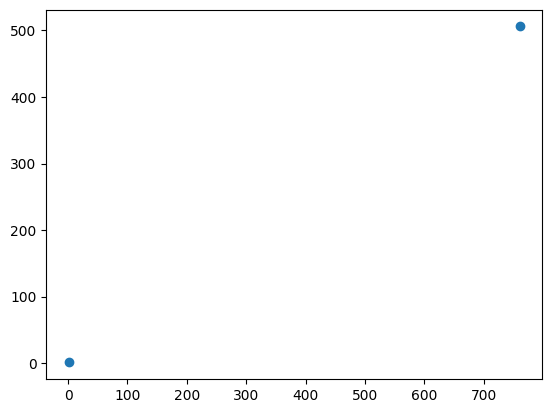

In [61]:
plt.scatter(stats_dict["original_size_w"], stats_dict["original_size_h"])
plt.show()

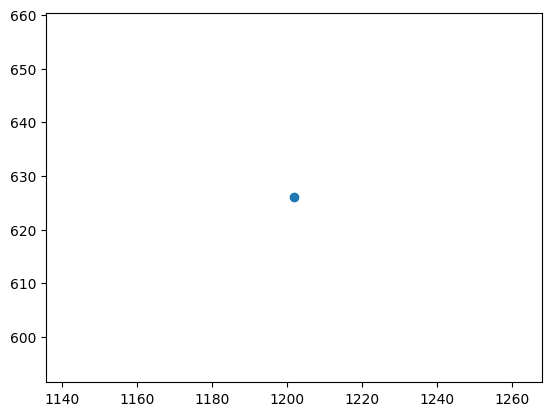

In [62]:
plt.scatter(stats_dict["final_size_w"], stats_dict["final_size_h"])
plt.show()

In [63]:
import statistics as st

In [64]:
print(st.median(stats_dict["final_size_w"]))
print(st.median(stats_dict["final_size_h"]))

1202
626


In [65]:
print(np.quantile(stats_dict["final_size_w"], [0,0.25,0.5,0.75,1]))
print(np.quantile(stats_dict["final_size_h"], [0,0.25,0.5,0.75,1]))

[1202. 1202. 1202. 1202. 1202.]
[626. 626. 626. 626. 626.]


In [66]:
sum(stats_dict["final_size_w"])/len(stats_dict["final_size_w"])

1202.0

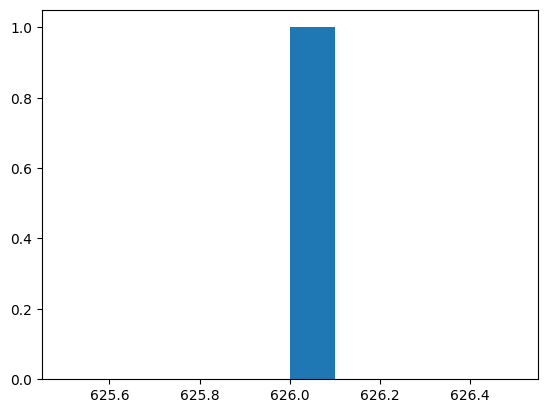

In [67]:
counts, bins = np.histogram(stats_dict["final_size_h"])
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [68]:
# max original width and image dim for that

# max original width and image dim for that

# max original width and image dim for that

# max original width and image dim for that

### Convert Input to Image

In [69]:
# os.path.exists("/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/document-vqa/data/new_input")

In [70]:
def convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice=None, save_dir="", \
                         sample_subset = 10, crop_padding = 30, remove_html_file = True, remove_pdf_file = True, \
                         params=None):
    
    idx_list = pid_splits[source] 
    idx_list = [int(idx) for idx in idx_list]
    
    if sample_subset is not None:
        idx_list = idx_list[:sample_subset]
        source = "tiny_" + source
    
    # create save directory if it does not exist
    save_dir = os.path.join(save_dir, source)
        
    if os.path.exists(save_dir) == False:
        os.makedirs(save_dir)
        print("Save directory created")
    else:
        print("Save directory already present")
        
    
    for sample_num in idx_list:
        
        # create html template
#         html_template = create_html_template(html_template_choice)
        html_template = create_html_file_modular(params, problem_list, sample_num=sample_num)
        html_file = create_html_file(html_template, problem_list, sample_num)
        
        # save tmp html file
        save_html_file(html_file, source, sample_num, save_dir=save_dir)
        
        # tmp and final filenames
        tmp_hpi_filename = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        img_filename = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        
        # convert tmp html to tmp pdf & delete tmp html file
        convert_html_to_pdf(tmp_hpi_filename, tmp_hpi_filename)
        
        # convert tmp pdf to image & delete tmp pdf file
        convert_pdf_to_image(tmp_hpi_filename, img_filename)
        
        # crop whitespace
        remove_white_space(f"{img_filename}.jpg")
        
        # cleaning by removing tmp files
        if remove_html_file:
            os.remove(f"{tmp_hpi_filename}.html")
        
        if remove_pdf_file:
            os.remove(f"{tmp_hpi_filename}.pdf")

In [71]:
params = {
    "set_question_as_header": False
}

In [60]:
# convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice = "img", 
#                      save_dir=os.path.join(os.getcwd(), "data", "new_data"), sample_subset = 10, 
#                      crop_padding = 30, params = params)

In [61]:
# convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice = "img", 
#                      save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 20 , 
#                      crop_padding = 30, params = params)

In [62]:
# convert_input_to_img(problem_list, pid_splits, source="val", html_template_choice = "img", 
#                      save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 4, 
#                      crop_padding = 30, params = params)

In [63]:
# convert_input_to_img(problem_list, pid_splits, source="test", html_template_choice = "img", 
#                      save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 4, 
#                      crop_padding = 30, params = params)

# Create custom loading and training template

## Convert Science to dataset (header_text, image, output) - Dataloader - Collator

In [72]:
options = ["A", "B", "C", "D", "E"]

In [73]:
output_format = "AE"

In [74]:
ScienceQA = namedtuple("ScienceQA", "sample_num header_text image image_mean image_std output")

In [75]:
def preprocess_image_pix2struct(image):
    im_arr = np.array(image)
    im_arr16 = im_arr.astype(np.float16)
    
    im_arr16_mean = np.mean(im_arr16)
    im_arr_16_tstd = np.sqrt(np.mean((im_arr16 - im_arr16_mean)**2))
    N = im_arr16.shape[0]*im_arr16.shape[1]*im_arr16.shape[2]
    im_arr16_std = max(im_arr_16_tstd, 1.0/np.sqrt(N))

    im_arr16_final = (im_arr16 - im_arr16_mean)/im_arr16_std
    
    im_tensor = torch.tensor(im_arr16_final)
#     print(im_tensor.shape)
   
    return im_tensor, im_arr16_mean, im_arr16_std

In [76]:
def visualize_processed_image(image, mean, std):
    image  = np.array(image * std + mean, dtype = np.uint8)
    plt.imshow(image)
    plt.show()

In [77]:
test_image_filename = os.path.join(os.getcwd(), "data","new_data","unimodal","train",f"{problem_list[1]['split']}_{1}")

In [78]:
image = Image.open(f"{test_image_filename}.jpg")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 image = Image.open(f"{test_image_filename}.jpg")                                             │
│   2                                                                                              │
│                                                                                                  │
│ /Users/rohanwadhawan/miniconda3/envs/nlg/lib/python3.10/site-packages/PIL/Image.py:3236 in open  │
│                                                                                                  │
│   3233 │   │   filename = fp                                                                     │
│   3234 │                                                                                         │
│   3235 │   if filename:                                                                          │
│ ❱ 3236 │   │   fp = builtins.open(filename, "rb")                                                │
│   3237 │   │   exclusive_fp = True                                                               │
│   3238 │                                                                                         │
│   3239 │   try:                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/eeevqa/data/new_data/unimodal/train/train_1.jpg'

In [ ]:
pre_image, pre_mean, pre_std = preprocess_image_pix2struct(image)

In [ ]:
# print(pre_image)
# np.unique(pre_image)

In [ ]:
visualize_processed_image(pre_image, pre_mean, pre_std)

In [79]:
def create_one_scienceqa_example(problem_list, img_filename="", sample_num=1, output_format="AE", options = None, preprocess_image=None):
    
    # header text
    header_text = problem_list[sample_num]["question"] + " " + get_choice_text(problem_list[sample_num], options)
    
    #input
    image = Image.open(f"{img_filename}.jpg")
    image_mean = 0
    image_std = 0
    if preprocess_image is not None:
        image, image_mean, image_std = preprocess_image(image)
    
    # Outputs
    if output_format == 'A':
        output = f"Answer: The answer is {options[problem_list[sample_num]['answer']]}."
    elif output_format == 'AE':
        output = f"Answer: The answer is {options[problem_list[sample_num]['answer']]}. BECAUSE: {problem_list[sample_num]['solution']}"
    elif output_format == 'EA':
        output = f"Answer: {problem_list[sample_num]['solution']} The answer is {options[problem_list[sample_num]['answer']]}."

    output = output.replace("  ", " ").strip()
    if output.endswith("BECAUSE:"):
        output = output.replace("BECAUSE:", "").strip()
    
    scienceqa_example = ScienceQA(sample_num, header_text, image, image_mean, image_std, output)
    return scienceqa_example

In [80]:
sample_num = 1
test_image_filename = os.path.join(os.getcwd(), "data", "html_files", f"{problem_list[sample_num]['split']}_{sample_num}")
test_example = create_one_scienceqa_example(problem_list, img_filename=test_image_filename, 
                                  sample_num=sample_num, output_format=output_format, options = options,
                                    preprocess_image = None) #preprocess_image_pix2struct)

In [81]:
print(test_example.header_text)
test_example.image.show()
# print(test_example.processed_image)
print(test_example.output)


Which of these states is farthest north? (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma
Answer: The answer is A. BECAUSE: To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.


In [82]:
def convert_scienceqa_to_dataset(problem_list, pid_splits, source="train", save_dir = "", output_format="AE", \
                                 options = None, preprocess_image = None, sample_subset = None):
    
    
    idx_list = pid_splits[source] 
    idx_list = [int(idx) for idx in idx_list]
    
    if sample_subset is not None:
        idx_list = idx_list[:sample_subset]
        source = "tiny_"+source
        
    save_dir = os.path.join(save_dir, source)    
    
    dataset = []
    for sample_num in idx_list:
        ifile = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        dataset.append(create_one_scienceqa_example(problem_list, img_filename=ifile, \
                                                    sample_num=sample_num, output_format=output_format, \
                                                    options = options, preprocess_image = preprocess_image))
    return dataset
        

In [83]:
# source = "train"
# sample_subset = None # 20
# train_dataset = convert_scienceqa_to_dataset(problem_list, pxxxid_splits, source=source, \
#                       save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
#                       options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

In [84]:
# source = "val"
# sample_subset = None # 4
# val_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \
#                       save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
#                       options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

In [85]:
# source = "test"
# sample_subset = None # 4
# test_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \
#                       save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
#                       options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

In [86]:
# minitrain_dataset

#### Save dataset

In [87]:
def save_dataset(dataset, save_dir="", filename=""):
    pickle_filename = os.path.join(save_dir, filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump(dataset, f)

In [88]:
# save_dataset(
#     train_dataset,
#     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
#     filename = "minitrain.pkl"
# )

In [89]:
# save_dataset(
#     val_dataset,
#     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
#     filename = "minival.pkl"
# )

In [90]:
# save_dataset(
#     test_dataset,
#     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
#     filename = "minitest.pkl"
# )

##### Load Test

In [92]:
# ScienceQA = namedtuple("ScienceQA", "sample_num header_text image text_context lecture image_mean image_std output")

# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "multimodal", "minitrain.pkl")
# with open(pickle_filename, 'rb') as f:
#     minitrain_dataset = pickle.load(f)

In [93]:
# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "unimodal", "1","minival.pkl")
# with open(pickle_filename, 'rb') as f:
#     minival_dataset = pickle.load(f)

In [94]:
# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "minitest.pkl")
# with open(pickle_filename, 'rb') as f:
#     minitest_dataset = pickle.load(f)

In [95]:
# temp_minitrain[0]

### Dataloader

In [96]:
MAX_PATCHES = 1024 # make it 2048 for base and 4096 for large

class VQADataset(Dataset):
    def __init__(self, dataset, processor, output_format="AE"):
        self.dataset = dataset
        self.processor = processor
        self.output_format = output_format

    def __len__(self):
        return len(self.dataset)

    def __gettext__(self, idx):
        return len(self.dataset[idx].output.split(" "))
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item.image, return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
    

        if self.output_format == "AE":
            encoding["text"] = item.output
        elif self.output_format == "A":
            encoding["text"] = item.output.split("BECAUSE:")[0].strip()
        elif self.output_format == "EA":
            split_text = item.output.split("BECAUSE:")
            if len(split_text)==1:
                encoding["text"] = split_text[0].strip()
            else:
                answer = split_text[0].split("Answer: The answer is ")[1].split(".")[0].strip()
                explanation = split_text[1].strip()
                encoding["text"] = f"Answer: {explanation} The answer is {answer}."
        encoding["sample_num"] = item.sample_num
        return encoding

### Load model and processor

In [285]:
processor = AutoProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")
# model.half()

In [286]:
# processor.image_processor.do_convert_rgb = False
# processor.image_processor.do_normalize = False
processor.image_processor.convert_fp16 = False

### Data Collator



In [287]:
def collator(batch):
    new_batch = {"flattened_patches":[], "attention_mask":[]}
    texts = [item["text"] for item in batch]

    text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=512)
    new_batch["labels"] = text_inputs.input_ids

    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])
    new_batch["sample_num"] = [item["sample_num"] for item in batch]

    return new_batch

### Create the necessary variable

In [290]:
minitrain_vqadataset = VQADataset(minitrain_dataset, processor, output_format="A")
minitrain_dataloader = DataLoader(minitrain_vqadataset, shuffle=True, batch_size=1, collate_fn=collator)

In [299]:
len(minitrain_dataloader)

1272

In [298]:
next(iter(minitrain_dataset)).image

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

In [291]:
data_sample = next(iter(minitrain_dataloader))

In [292]:
data_sample

{'flattened_patches': tensor([[[1.0000, 1.0000, 0.5848,  ..., 0.5704, 0.5704, 0.5704],
          [1.0000, 2.0000, 0.5848,  ..., 0.5829, 0.5829, 0.5829],
          [1.0000, 3.0000, 0.5848,  ..., 0.5848, 0.5848, 0.5848],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]]),
 'labels': tensor([[11661,   305,   310,  1071,   296,   273,   278,   274,     1,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              

In [459]:
minival_vqadataset = VQADataset(minival_dataset, processor)
minival_dataloader = DataLoader(minival_vqadataset, shuffle=True, batch_size=2, collate_fn=collator)

In [460]:
minitest_vqadataset = VQADataset(minitest_dataset, processor)
minitest_dataloader = DataLoader(minitest_vqadataset, shuffle=True, batch_size=2, collate_fn=collator)

## Evaluate Model

In [461]:
def extract_explanation(text):
    text = re.sub(r"The answer is [A-Z]. BECAUSE: ", "", text)
    return text


In [462]:
def score_rouge(str1, str2):
    rouge = Rouge(metrics=["rouge-l"])
    scores = rouge.get_scores(str1, str2, avg=True)
    rouge_l = scores['rouge-l']['f']
    return rouge_l

In [463]:
def calculate_rouge(results, data): # expects results to be dictionary
    rouges = []
    for qid, output in results.items():
        prediction = extract_explanation(output)
        target = data[qid]["solution"]
        target = target.strip()
        if prediction == "":
            continue
        if target == "":
            continue
        rouge = score_rouge(target, prediction)
        rouges.append(rouge)

    avg_rouge = sum(rouges) / len(rouges)
    return avg_rouge

In [464]:
def extract_answer(output):
    pattern = re.compile(r'The answer is ([A-Z]).')
#     print(output)
#     print(type(output))
#     print(pattern.findall("hello"))
    res = pattern.findall(output)
    
    if len(res) == 1:
        answer = res[0]  # 'A', 'B', ...
    else:
        answer = "FAILED"
    return answer

In [465]:
def get_pred_idx(prediction, choices, options):
    """
    Get the index (e.g. 2) from the prediction (e.g. 'C')
    """
    if prediction in options[:len(choices)]:
#         print("options pred: ", options.index(prediction))
        return options.index(prediction)
    else:
#         print("rand choice: ", random.choice(range(len(choices))), type(random.choice(range(len(choices)))))
        return random.choice(range(len(choices)))

In [478]:
def calculate_acc(results, data, options=None):
    acc = []
    for qid, output in results.items():
        prediction = get_pred_idx(extract_answer(output), \
                                             data[qid]["choices"], options = options)
#         print("target-answer: ", data[qid]["answer"], type(data[qid]["answer"]))
        target = data[qid]["answer"]

        if prediction == "":
            continue
        if target == "":
            continue
        acc.append(prediction == target)

    avg_acc = sum(acc) / len(acc)
    return avg_acc

In [479]:
def create_result_dict(result_list, qids):
    return dict([(qids[i], result_list[i]) \
                           for i in range(len(result_list))])

In [480]:
def create_dummy_example(problem_list, sample_num=1, output_format="AE", options = None):
    
    if np.random.randint(1, len(problem_list)+1)/50 > 0.5:
        new_sample_num = sample_num
    else:
        new_sample_num = np.random.randint(1, len(problem_list)+1)
    
    # Outputs
    if output_format == 'A':
        output = f"Answer: The answer is {problem_list[new_sample_num]['answer']}."
    elif output_format == 'AE':
        output = f"Answer: The answer is {problem_list[new_sample_num]['answer']}. BECAUSE: {problem_list[new_sample_num]['solution']}"
    elif output_format == 'EA':
        output = f"Answer: {problem_list[new_sample_num]['solution']} The answer is {problem_list[new_sample_num]['answer']}."

    output = output.replace("  ", " ").strip()
    if output.endswith("BECAUSE:"):
        output = output.replace("BECAUSE:", "").strip()
    
    return output

In [481]:
# np.random.randint(0, 50)/50

In [482]:
dummy_problem_list = problem_list[:50]

In [483]:
dummy_example_list = [create_dummy_example(dummy_problem_list, i+1, output_format="AE", options=options) \
                      for i in range(len(dummy_problem_list))]

In [484]:
dummy_example_dict = create_result_dict(dummy_example_list, np.arange(1, len(dummy_example_list)+1))

In [485]:
# print(dummy_example_dict)

In [486]:
calculate_rouge(dummy_example_dict, dummy_problem_list)

0.2189008770326228

In [487]:
calculate_acc(dummy_example_dict, dummy_problem_list, options)

0.21428571428571427

In [488]:
# problem_list[1]["choices"]

## Train the model

In [489]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [490]:
# model

In [491]:
def training_loop(problem_list, train_dataloader, val_dataloader, epochs, lr, options, device, checkpoint_dir, log_epoch=2):
    EPOCHS = epochs

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    device = device
    model.to(device)

    model.train()
    
    data_logger = {
        "accuracy_stats":{
        'train': [],
        "val": []
      },
        "rouge_stats":{
        'train': [],
        "val": []
       },
      "loss_stats":{
          'train': []
      }
    }
    
    for epoch in range(EPOCHS):

        print("Epoch:", epoch)
        train_epoch_loss = 0.0

        for idx, batch in enumerate(train_dataloader):
            labels = batch.pop("labels").to(device)
            flattened_patches = batch.pop("flattened_patches").to(device)
            attention_mask = batch.pop("attention_mask").to(device)

            outputs = model(flattened_patches=flattened_patches,
                            attention_mask=attention_mask,
                            labels=labels)
#             print(outputs)
            loss = outputs.loss

            print("Loss:", loss.item())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            train_epoch_loss += loss.item()
            
#             if (idx+1)% 2 ==0 :
#                 break
        
        data_logger["loss_stats"]['train'].append(train_epoch_loss/len(train_dataloader))
        
        if (epoch + 1) % log_epoch == 0:
            with torch.no_grad():

                train_results = []
                train_qids = []
                for j, train_batch in enumerate(train_dataloader):
                    eflattened_patches = train_batch.pop("flattened_patches").to(device)
                    eattention_mask = train_batch.pop("attention_mask").to(device)
                    predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
                    train_results+=predictions
                    train_qids+=[b["sample_num"] for b in train_batch]

#                     print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

                train_result_dict = create_result_dict(train_results, train_qids)
                data_logger["accuracy_stats"]['train'].append(calculate_acc(train_result_dict, problem_list, options))
                data_logger["rouge_stats"]['train'].append(calculate_rouge(train_result_dict, problem_list))
                
                val_results = []
                val_qids = []
                for j, val_batch in enumerate(val_dataloader):
                    eflattened_patches = val_batch.pop("flattened_patches").to(device)
                    eattention_mask = val_batch.pop("attention_mask").to(device)
                    predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
                    val_results+=predictions
                    val_qids+=[b["sample_num"] for b in val_batch]

#                     print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

                val_result_dict = create_result_dict(val_results, val_qids)
                data_logger["accuracy_stats"]['val'].append(calculate_acc(val_result_dict, problem_list, options))
                data_logger["rouge_stats"]['val'].append(calculate_rouge(val_result_dict, problem_list))


            model.train()
            
    return data_logger


In [446]:
# a = []
# for i in range(10):
#     a += [2,2]
# print(a)

In [447]:
# processor

In [448]:
epochs = 4
lr = 1e-5
checkpoint_dir = os.path.join(os.getcwd(),"results", "checkpoints")

In [449]:
data_logger = training_loop(problem_list, minitrain_dataloader, minival_dataloader, 
              epochs, lr, options, device, checkpoint_dir, log_epoch=2)

Epoch: 0
Loss: 35.94094467163086
Loss: 34.90445327758789


## Inference Code

In [501]:
def model_loader(params):
    # create net
#     net = params["model_fn"]()
    net = params["model"]
    net.to(params["device"])

    # load weights from VAE_classifier_autocoder model and freeze those layers
    checkpoint_path = os.path.join(params["output_dir"], params["checkpoint_name"])
    net.load_state_dict(torch.load(checkpoint_path, map_location = params["device"])["model_state_dict"])
    return net

In [502]:
def get_subset_results(params):
    
    # load model
    net = model_loader(params)
    
    # predict outputs
    results = [] # change code here
    qids = []
    for idx, batch in enumerate(params["dataloader"]):
        eflattened_patches = batch.pop("flattened_patches").to(device)
        eattention_mask = batch.pop("attention_mask").to(device)
        predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
        text_predictions = processor.batch_decode(predictions, skip_special_tokens=True)
        results+=text_predictions
        qids+=batch['sample_num']
        if (idx+1)%100 == 0:
            print(f"{params['datasplit']} {idx+1}")

    # create results dict
    results_dict = create_result_dict(results, qids)
    
    # calculate average rouge-L and accuracy
    avg_acc = calculate_acc(results_dict, params["problem_list"], params["options"])
    
    avg_rouge = calculate_rouge(results_dict, params["problem_list"])
    
    print(f"Average accuracy: {avg_acc} \n Average Rouge-L score: {avg_rouge}")
    
    return avg_acc, avg_rouge

In [505]:
params = {
    "model": Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base"),
    "device": device,
    "output_dir":os.path.join(os.getcwd(), "results", "checkpoints"),
    "checkpoint_name":"pix2struct_sqa_1024_512_5.pt",
    "problem_list":problem_list,
    "dataloader":minival_dataloader,
    "datasplit":"minival",
    "options":options
}

In [506]:
avg_acc, avg_rouge = get_subset_results(params)

minival 100
minival 200
Average accuracy: 0.41509433962264153 
 Average Rouge-L score: 0.025421022055376396


# Data visualization

In [101]:
def visualize_input_distribution(meta_data_dict, param="question"):
    counts, bins = np.histogram(meta_data_dict[param]["list"])
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()
    

In [139]:
def get_data_stats(df,  idx_list = None, tokenizer = None):
    meta_data_dict = {
        "question": {
        "list":[],
        "min_len":10000,
        "max_len":0,
        "avg_len":0.0
        },
        
    "lecture": {
        "list":[],
        "min_len":10000,
        "max_len":0,
        "avg_len":0.0
     },
    "solution": {
        "list":[],
        "min_len":10000,
        "max_len":0,
        "avg_len":0.0
        },
    "hint": {
    "list":[],
    "min_len":10000,
    "max_len":0,
    "avg_len":0.0
    },
        "img_cnt":0,
        
    }
    
    if idx_list is None:
        iterate_list = df.keys().values
    else:
        iterate_list = idx_list
    
    for i in iterate_list:
        
        if tokenizer is None:
            qlen = len(df[i]["question"].split(" "))
            llen = len(df[i]["lecture"].split(" "))
            slen = len(df[i]["solution"].split(" "))
            hlen = len(df[i]["hint"].split(" "))
        
        else:
            qlen = len(tokenizer.tokenize(df[i]["question"]))
            llen = len(tokenizer.tokenize(df[i]["lecture"]))
            slen = len(tokenizer.tokenize(df[i]["solution"]))
            hlen = len(tokenizer.tokenize(df[i]["hint"]))
            

        #check min, max and avg length of question
        if qlen < meta_data_dict["question"]["min_len"]:
            meta_data_dict["question"]["min_len"] = qlen
        
        if qlen > meta_data_dict["question"]["max_len"]:
            meta_data_dict["question"]["max_len"] = qlen
        
        meta_data_dict["question"]["avg_len"]+= qlen
        
        meta_data_dict["question"]["list"].append(qlen)

        #check min, max and avg length of lecture
        if llen < meta_data_dict["lecture"]["min_len"]:
            meta_data_dict["lecture"]["min_len"] = llen
        
        if llen > meta_data_dict["lecture"]["max_len"]:
            meta_data_dict["lecture"]["max_len"] = llen
        
        meta_data_dict["lecture"]["avg_len"]+= llen
        
        meta_data_dict["lecture"]["list"].append(llen)


        #check min, max and avg length of rationale / solution
        if slen < meta_data_dict["solution"]["min_len"]:
            meta_data_dict["solution"]["min_len"] = slen
        
        if slen > meta_data_dict["solution"]["max_len"]:
            meta_data_dict["solution"]["max_len"] = slen
        
        meta_data_dict["solution"]["avg_len"]+= slen
        
        meta_data_dict["solution"]["list"].append(slen)
        
        #check min, max and avg length of text context / hint field
        if hlen < meta_data_dict["hint"]["min_len"]:
            meta_data_dict["hint"]["min_len"] = hlen
        
        if hlen > meta_data_dict["hint"]["max_len"]:
            meta_data_dict["hint"]["max_len"] = hlen
        
        meta_data_dict["hint"]["avg_len"]+= hlen
        
        meta_data_dict["hint"]["list"].append(hlen)

        #check # questions with images
        if df[i]["image"] is not None:
            meta_data_dict["img_cnt"]+=1

    meta_data_dict["question"]["avg_len"]/= len(df.keys().values)
    meta_data_dict["lecture"]["avg_len"]/= len(df.keys().values)
    meta_data_dict["solution"]["avg_len"]/= len(df.keys().values)
    meta_data_dict["hint"]["avg_len"]/= len(df.keys().values)

    # printing stats
    print(f"Question min len: {meta_data_dict['question']['min_len']} - max len: {meta_data_dict['question']['max_len']} - avg len: {meta_data_dict['question']['avg_len']}")
    print(f"Lecture min len: {meta_data_dict['lecture']['min_len']} - max len: {meta_data_dict['lecture']['max_len']} - avg len: {meta_data_dict['lecture']['avg_len']}")
    print(f"Solution min len: {meta_data_dict['solution']['min_len']} - max len: {meta_data_dict['solution']['max_len']} - avg len: {meta_data_dict['solution']['avg_len']}")
    print(f"Hint min len: {meta_data_dict['hint']['min_len']} - max len: {meta_data_dict['hint']['max_len']} - avg len: {meta_data_dict['hint']['avg_len']}")
    print(f"Samples with images: {meta_data_dict['img_cnt']} out of a total of: {len(iterate_list)}")
    
    return meta_data_dict


In [ ]:
def get_datastats_all_split(problem_list, pid_splits):
    for split in pid_splits.keys():
        print(f"----- Printing stats for split {split} -----")
        get_datastats(problem_list, get_specific_split(pid_splits, split_name = split))
        print(f"\n-----  -----\n")

get_datastats_all_split(problem_list, pid_splits)

In [140]:
meta_data_dict = get_data_stats(problem_list)

Question min len: 3 - max len: 140 - avg len: 11.8439268200679
Lecture min len: 1 - max len: 469 - avg len: 101.15668615616748
Solution min len: 1 - max len: 429 - avg len: 41.78135609204074
Hint min len: 1 - max len: 306 - avg len: 17.037957374575633
Samples with images: 10332 out of a total of: 21208


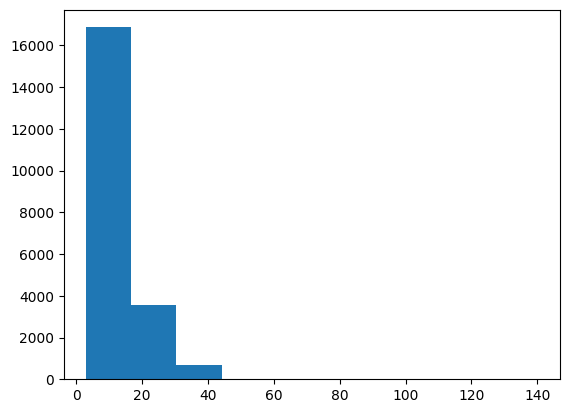

In [133]:
visualize_input_distribution(meta_data_dict, param = "question")

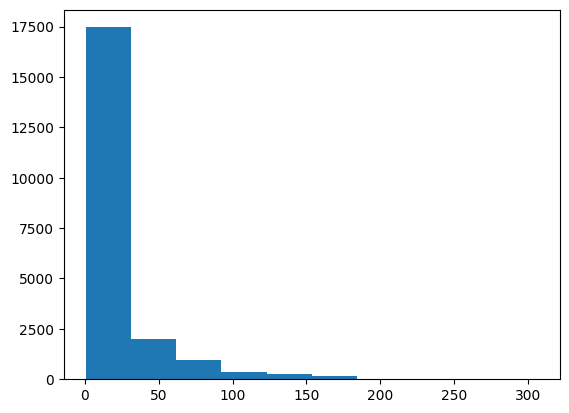

In [134]:
visualize_input_distribution(meta_data_dict, param = "hint")

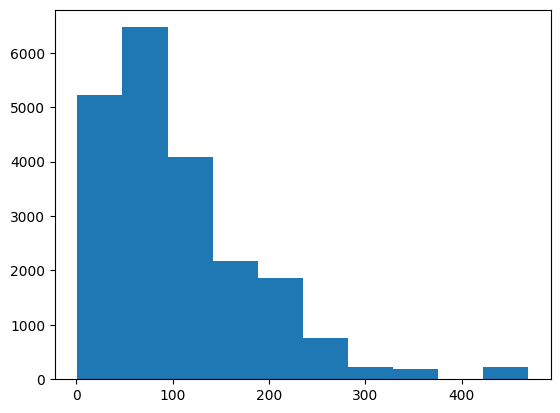

In [135]:
visualize_input_distribution(meta_data_dict, param = "lecture")

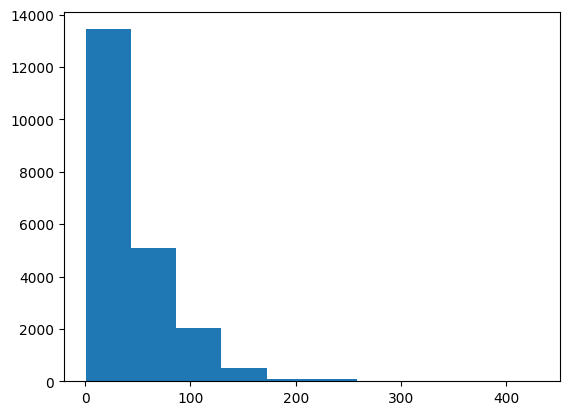

In [136]:
visualize_input_distribution(meta_data_dict, param = "solution")

### Token length stats

In [106]:
from transformers import AutoTokenizer, DebertaModel, AutoConfig, AutoTokenizer, AutoModel

In [107]:
config = AutoConfig.from_pretrained(pretrained_model_name_or_path="microsoft/deberta-v3-base")

In [108]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [111]:
model = AutoModel.from_pretrained(pretrained_model_name_or_path="microsoft/deberta-v3-base",
                                  config=config)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
input_text = "Hello, my dog is cute"

In [138]:
print(type(tokenizer.tokenize(input_text)))

<class 'list'>


In [127]:
inputs = tokenizer(input_text, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[   1, 5365,  261,  312, 1560,  269, 3363,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [128]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [129]:
print(last_hidden_states.shape) # batch size, seq length, hidden size

torch.Size([1, 8, 768])


### Visualize tokenized input

In [142]:
meta_data_dict = get_data_stats(problem_list, idx_list=None, tokenizer = tokenizer)

Question min len: 4 - max len: 167 - avg len: 14.272915880799697
Lecture min len: 0 - max len: 738 - avg len: 122.60632780082987
Solution min len: 0 - max len: 556 - avg len: 51.45963787250094
Hint min len: 0 - max len: 400 - avg len: 19.9371463598642
Samples with images: 10332 out of a total of: 21208


In [143]:
Question min len: 3 - max len: 140 - avg len: 11.8439268200679
Lecture min len: 1 - max len: 469 - avg len: 101.15668615616748
Solution min len: 1 - max len: 429 - avg len: 41.78135609204074
Hint min len: 1 - max len: 306 - avg len: 17.037957374575633
Samples with images: 10332 out of a total of: 21208


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Question min len: 3 - max len: 140 - avg len: 11.8439268200679                                   │
│          ▲                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

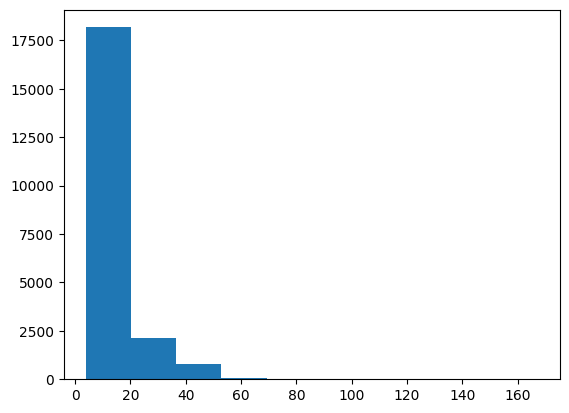

In [144]:
visualize_input_distribution(meta_data_dict, param = "question")

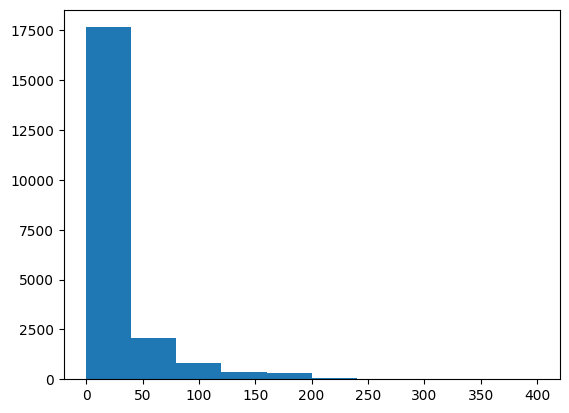

In [145]:
visualize_input_distribution(meta_data_dict, param = "hint")

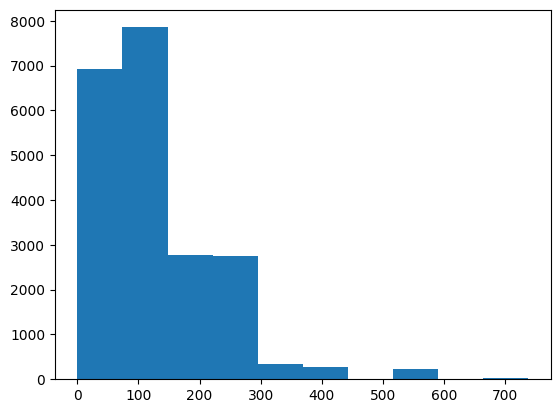

In [146]:
visualize_input_distribution(meta_data_dict, param = "lecture")

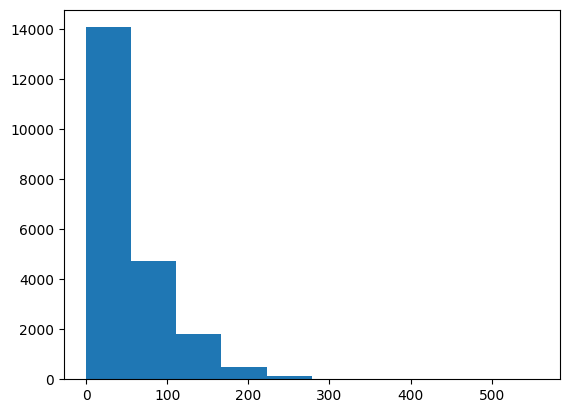

In [147]:
visualize_input_distribution(meta_data_dict, param = "solution")

# Playground

In [726]:
in_text = "The answer is 1. cdavcdv"

In [718]:
out_text = re.sub(r"The answer is [A-Z]. BECAUSE: ", "", in_text)

In [719]:
print(out_text)

The answer is 1. BECAUSE: cdavcdv


In [728]:
out_text2 = in_text.split("BECAUSE:")[0].strip()

In [729]:
print(out_text2)

The answer is 1. cdavcdv


In [730]:
len(out_text2) == len(in_text)

True

In [772]:
t1="ferf"
t2="cefvev"
t3="ewfvfv"
t4=""
os.path.join(t1,t2,t3,t4)

'ferf/cefvev/ewfvfv/'

In [790]:
results = {
    1:{
        "true_false":True
    },
    7674:{
        "true_false":False
    },
    3451:{
        "true_false":False
    },
    2312:{
        "true_false":False
    },
}

In [793]:
print((sum([1 if results[key]["true_false"]==True else 0 for key in list(results.keys())])/ 4) * 100)

25.0


## Testing capacity of vanilla Pix2struct

In [101]:
base_model = "google/pix2struct-base"

In [102]:
configuration = Pix2StructConfig()

In [103]:
print(configuration)

Pix2StructConfig {
  "_commit_hash": null,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "is_encoder_decoder": true,
  "is_vqa": false,
  "model_type": "pix2struct",
  "pad_token_id": 0,
  "text_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "d_ff": 2048,
    "d_kv": 64,
    "decoder_start_token_id": 0,
    "dense_act_fn": "gelu_new",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout_rate": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 1,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
     

In [104]:
processor = AutoProcessor.from_pretrained(base_model)
model = Pix2StructForConditionalGeneration.from_pretrained(base_model)

In [105]:
print(model.config)

Pix2StructConfig {
  "_commit_hash": "956e2761626d0c37672c7741204a105ecd389245",
  "_name_or_path": "google/pix2struct-base",
  "architectures": [
    "Pix2StructForConditionalGeneration"
  ],
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "is_encoder_decoder": true,
  "is_vqa": false,
  "model_type": "pix2struct",
  "pad_token_id": 0,
  "text_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "d_ff": 2048,
    "d_kv": 64,
    "decoder_start_token_id": 0,
    "dense_act_fn": "gelu_new",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout_rate": 0.2,
    "early_stopping": false,
    "encoder_hidden_size": 768,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 1,
    "exponential_decay_lengt

In [493]:
# '''
# test_image_v1_layout1_img_context (same for both layouts)
# test_image_v1_layout1_tl_context (same for both layouts)
# test_image_v1_layout1_both_context
# test_image_v1_layout2_img_context
# test_image_v1_layout2_tl_context
# test_image_v1_layout2_both_context

# test_image_v2_layout1_img_context (same for both layouts)
# test_image_v2_layout1_tl_context (same for both layouts)
# test_image_v2_layout1_both_context
# test_image_v2_layout2_img_context
# test_image_v2_layout2_tl_context
# test_image_v2_layout2_both_context

# minitrain
# version 1

# img: 
#     289: <img_src=What-is-the-capital-of-Washington-1>, 
#     385: <img_src=map-of-the-colony-shown-in-the-state-of-delaware-1 img_alt=The Colony of Delaware>, 
#     852: <img_src=map-of-the-colony-shown-1 img_alt=Map of the Colony shown>

# tl: 
#     37: <img_src=image001>, 
#     90: <img_src=overall-supply-supplies-and-supplies-in-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-springtown-spring, 
#     97: <img_src=How-long-is-a-walk-across-Central-Park-in-New-York-City>, 
#     105: <img_src=select-the-reptile>, 
#     146: <img_src=text-uses-traditional-sense>, 
#     419: <img_src=image img_alt=Using only these supplies, which question can Logan investigate with an experiment?>

# both l1: 
#         107: <img_src=solvent-volume-40-ml-solvent-volume-40-ml img_alt=solvent volume 40 ml solvent volume 40 ml>,
#         130: <img_src=Debbie-and-Madelyn-trade-to-each-get-what-they-want img_alt=What can Debbie and Madelyn trade to each get what they want? (A) Madelyn can trade her broccoli for Debbie's oranges. (B) Debbie can trade her tomatoes for Madelyn's broccoli. (C) Debbie can trade her tomatoes for Madelyn's sandwich. (D) Madelyn can trade her almonds for Debbie's tomatoes. (E) Trade happens when people agree to exchange goods and services. People give up something to get something else. Sometimes people barter, or directly exchange one good or service for another. Debbie and Madelyn open their lunch boxes in the school cafeteria. Both of them could be happier with their lunches. Debbie wanted broccoli in her lunch and Madelyn was hoping for tomatoes. Look at the images of their lunches. Then answer the question below.>,
#         143:<img_src=mojave-yucca-food-chain>,
#         208: <img_src=100_00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,
#         346: <img_src=Which-property-do-these-two-objects-have-in-common>,
#         405: <img_src=Percy-and-Cole-trade-to-each-get-what-they-want-1 img_alt=Percy and Cole trade to each get what they want>,

# both l2: 
#         107: <img_src=solvent-volume-40-ml>,
#         130: <img_src=Debbies-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns-lunch-madelyns,
#         143:<img_src=mojave-yucca-food-chain-1>,
#         208: <img_src=1500x1500-1 img_alt=Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment. Imagine an experiment with two groups of daffodil plants. One group of plants was grown in sandy soil, and the other was grown in clay soil. Then, the height of each plant was measured. First, identify the part of the experiment that was tested. The part of an experiment that is tested usually involves the part of the experimental setup that is different or changed. In the experiment described above, each group of plants was grown in a different type of soil. So, the effect of growing plants in different soil types was tested. Then, identify the part of the experiment that was measured. The part of the experiment that is measured may include measurements and calculations. In the experiment described above, the heights of the plants in each group were measured. Experiments can answer questions about how the part of the experiment that is tested affects the part that is measured. So, the experiment described above can answer questions about how soil type affects the part that is measured. Examples of questions that this experiment can answer include: Does soil type affect the height of daffodil plants? Do daffodil plants in sandy soil grow taller than daffodil plants in clay soil? Are daffodil plants grown in sandy soil shorter than daffodil plants grown in clay soil?>,
#         346:<img_src=Which-property-do-these-two-objects-have-in-common>,
#         405: <img_src=Percy-and-Cole-trade-lunch-lunches-1 img_alt=Percy and Cole trade lunch lunch lunch lunch lunch lunch lunch lunch lunch lunch lunch...,

# version 2

# img: 
#     289: <img_src=What-is-the-capital-of-Pennsylvania-A-Harrisburg-B-Trenton-C-Pittsburgh-D-Philadelphia img_alt=What is the capital of Pennsylvania? (A) Harrisburg (B) Trenton (C) Pittsburgh (D) Philadelphia>, 
#     385: <img_src=What-is-the-name-of-the-colony-shown-A-Maryland-B-New-Jersey-C-Rhode-Island-D-Delaware img_alt=What is the name of the colony shown? (A) Maryland (B) New Jersey (C) Rhode Island (D) Delaware>, 
#     852: <img_src=what-is-the-name-of-the-colony-shown-a-connecticut-b-new-hampshire-c-massachusetts-d-wisconsin img_alt=What is the name of the colony shown? (A) Connecticut (B) New Hampshire (C) Massachusetts (D) Wisconsin>

# tl: 
#     37: <img_src=Is-the-following-trait-inherited-or-acquired-Katy-plays-soccer.-(A)-inherited-(B)-acquired img_alt=Is the following trait inherited or acquired? Katy plays soccer. (A) inherited (B) acquired>, 
#     90: <img_src=Overall-supply-is-the-total-amount-of-a-good-or-service-that-producers-make-and-sell.-There-are-several-things-that-can-make-overall-supply-go-up-or-down.-The-table-below-shows-how-changes-to-these-things-might-affect-overall-supply.-|-Resources-|-Number-of-producers-or-suppliers-|-Expected-change-in-demand-Supply-goes-up-|-when-resources-cost-less-or-are-easier-to-get-|-when-there-are-more-producers-or-suppliers-|-when-demand-is-expected-to-go-up-Supply-goes-down-|-when-resources-cost-more-or-are-harder-to-get-|-when-there-are-fewer-producers-or-suppliers-|-when-demand-is-expected-to-go-down-Suppliers-are-people-or-companies-that-make-goods-or-provide-services.-Suppliers-are-people-or-companies-that-sell-goods-or-services.-New-inventions-or-technologies-can-also-help-workers-produce-goods-and-services-more-quickly.-As-a-result-of-these-changes,-the-supply-of-a-good-or-service-will-often-go-up. img_alt=Overall supply is the total amount of a good or service that producers make and sell. There are several things that can make overall supply go up or down. The table below shows how changes to these things might affect overall supply. | Resources | Number of producers or suppliers | Expected change in demand Supply goes up | when resources cost less or are easier to get | when there are more producers or suppliers | when demand is expected to go up Supply goes down | when resources cost more or are harder to get | when there are fewer producers or suppliers | when demand is expected to go down Producers, 
#     97: <img_src=How-long-is-a-walk-across-Central-Park-in-New-York-City-3-centimeters-B-3-millimeters-C-3-kilometers-D-3-meters img_alt=How long is a walk across Central Park in New York City? (A) 3 centimeters (B) 3 millimeters (C) 3 kilometers (D) 3 meters>, 
#     105: <img_src=reptiles>, 
#     146: <img_src=Which-text-uses-the-word-literally-in-its-traditional-sense-A-Cara-adores-the-classic-Renaissance-style-of-the-Rialto-Bridge-in-Venice.-She-was-surprised-to-learn-that-the-bridge-remains-functional-even-though-it-is-literally-a-million-years-old.-B-Cara-adores-the-classic-Renaissance-style-of-the-Rialto-Bridge-in-Venice.-She-was-surprised-to-learn-that-the-bridge-remains-functional-even-though-it-is-literally-hundreds-of-years-old. img_alt=Which text uses the word literally in its traditional sense? (A) Cara adores the classic Renaissance style of the Rialto Bridge in Venice. She was surprised to learn that the bridge remains functional even though it is literally a million years old. (B) Cara adores the classic Renaissance style of the Rialto Bridge in Venice. She was surprised to learn that the bridge remains functional even though it is literally hundreds of years old.>, 
#     419: <>,

# both l1: 
#         107: <img_src=solvent-volume-40-ml img_alt=Which solution has a higher concentration of yellow particles? (A) neither; their concentrations are the same (B) Solution B (C) Solution A>,
#         130: <<img_src=Debbies-lunch-1 img_alt=Debbie's lunch> <img_src=Debbies-lunch-2 img_alt=Debbie's lunch>>, 
#         143: <img_src=mojave-yucca-food-chain-1 img_alt=In this food chain, the Mojave yucca is a producer. Why? (A) It eats another living thing. (B) It makes its own food.>,
#         208: <img_src=100_1000>,
#         346: <<img_src=which-property-do-these-two-objects-have-in-common-a-breakable-hard img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-2 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-3 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-4 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-5 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-1 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-1 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-1 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=which-property-do-these-two-objects-have-in-common-acorn-2 img_alt=Which property do these two objects have in common? (A,
#         405: <img_src=image001 img_alt=What can Percy and Cole trade to each get what they want? (A) Percy can trade his tomatoes for Cole's broccoli. (B) Cole can trade his broccoli for Percy's oranges. (C) Cole can trade his almonds for Percy's tomatoes. (D) Percy can trade his tomatoes for Cole's carrots. <0x0A><0x0A><0x0A>,

# both l2: 
#         107: <img_src=image001 img_alt=Which solution has a higher concentration of yellow particles? (A) neither; their concentrations are the same (B) Solution B (C) Solution A>,
#         130: <<img_src=Debbies_lunch_01 img_alt=Debbie's lunch> <img_src=Debbies_lunch_02 img_alt=Debbie's lunch> <img_src=Debbies_lunch_03 img_alt=Debbie's lunch> <img_src=Debbies_lunch_04 img_alt=Debbie's lunch> <img_src=Debbies_lunch_05 img_alt=Debbie's lunch> <img_src=Debbies_lunch_06 img_alt=Debbie's lunch> <img_src=Debbies_lunch_07 img_alt=Debbie's lunch> <img_src=Debbies_lunch_08 img_alt=Debbie's lunch> <img_src=Debbies_lunch_09 img_alt=Debbie's lunch> <img_src=Debbies_lunch_01 img_alt=Debbie's lunch> <img_src=Debbies_lunch_03 img_alt=Debbie's lunch> <img_src=Debbies_lunch_04 img_alt=Debbie's lunch> <img_src=Debbies_lunch_05 img_alt=Debbie's lunch> <img_src=Debbies_lunch_06 img_alt=Debbie's lunch> <img_src=Debbies_lunch_07 img_alt=Debbie's lunch> <img_src=Debbies_lunch_09 img_alt=Debbie's lunch> <img_src=Debbies_lunch_01 img_alt=Debbie's lunch> <img_src=Debbies_lunch_01 img_alt=Debbie's lunch> <img_src=Debbies_lunch_02 img_alt=Debbie's lunch,
#         143: <img_src=mojave-yucca-food-chain-1 img_alt=In this food chain, the Mojave yucca is a producer. Why? (A) It eats another living thing. (B) It makes its own food. This diagram shows a food chain from a desert ecosystem in Southern California. Every living thing needs food to stay alive. Living things get their food in different ways. A food chain shows how living things in an ecosystem get their food. Producers make their own food. Many producers use carbon dioxide, water, and sunlight to make sugar. This sugar is food for the producer. Consumers eat other living things. Consumers cannot make their own food.>,
#         208 <img_src=daffodil-plants-in-clay-soil-1024x683 img_alt=daffodil plants in clay soil>:
#         346:<<img_src=properties-1 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=properties-2 img_alt=Select the better answer. An object has different properties. A property of an object can tell you how it looks, feels, tastes, or smells. Different objects can have the same properties. You can use these properties to put objects into groups.> <img_src=properties-3 img_alt=Which property do these two objects have in common? (A) breakable (B) hard> <img_src=properties-4 img_alt=Select the better answer. An object has different properties. A property of an object can tell you how it looks, feels, tastes, or smells. Different objects can have the same properties. You canuse these properties to put objects into groups.> <img_src=properties-5 img_alt=Select the better answer. An object has different properties. A property of an object can tell you how it looks, feels, tastes, or smells. Different objects can have the same properties. You can use these properties to put objects into groups.> <img_src=properties-6 img_alt=Select the better answer. An object has different properties.> <img_src=properties-7 img_alt=Select the better answer. An object has different properties.> <img_src=properties-8 img_alt=Select the better answer. An object has different properties.> <img_src=properties-9 img_alt=Select the better answer. An object has different properties.> <img_src=properties-10 img_alt=Select the better answer. An object has different properties.> <img_src=properties-11 img_alt=Select the better answer. An object has different properties.> <img_src=properties-12 img_alt=Select the better answer. An object has different properties.> <img_src=properties-13 img_alt=Select the better answer. An object has different properties.> <img_src=properties-14 img_alt=Select the better answer. An object has different properties.> <img_src=properties-15 img_alt=Select the better answer. An object has different properties.> <,,
#         405: <>,


# '''

In [548]:
basic_img_path = "data/test_images/v2/layout2/test_image4.jpg"

In [549]:
test_img_path = os.path.join(os.getcwd(), basic_img_path)

max_patches = 2048
max_new_tokens = 512
patch_size = 16

In [550]:
test_img = Image.open(test_img_path)

In [551]:
encoding = processor(
                images=test_img, 
                return_tensors="pt", 
                add_special_tokens=True, 
                max_patches=max_patches)

In [552]:
flattened_patches = encoding["flattened_patches"]
attention_mask = encoding["attention_mask"]

In [553]:
# text_inputs = processor(
#     text=texts, 
#     padding=True, 
#     truncation=True, 
#     return_tensors="pt", 
#     add_special_tokens=True, 
#     max_length=max_new_tokens)

In [554]:
generated_ids = model.generate(
                flattened_patches=flattened_patches, 
                attention_mask=attention_mask, 
                max_new_tokens=max_new_tokens
                )  

In [555]:
text_predictions = processor.batch_decode(
                    generated_ids, 
                    skip_special_tokens=True
                    )[0]

In [556]:
print(text_predictions)

<img_src=daffodil-plants-in-clay-soil-1024x683 img_alt=daffodil plants in clay soil>


In [558]:
"tyfg{img_tag}jhjb{context_tag}jnj".format(img_source="bjn jn", context="jbn")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 "tyfg{img_tag}jhjb{context_tag}jnj".format(img_source="bjn jn", context="jbn")               │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'img_tag'